Datos cargados: (623892, 5)
Q1: 1182.0, Q3: 3469.0, IQR: 2287.0
Límite inferior: -2248.5, Límite superior: 6899.5


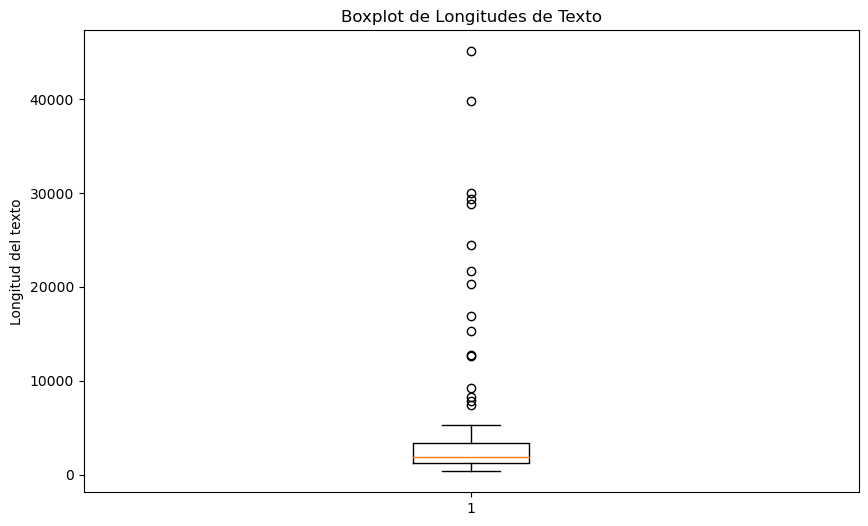

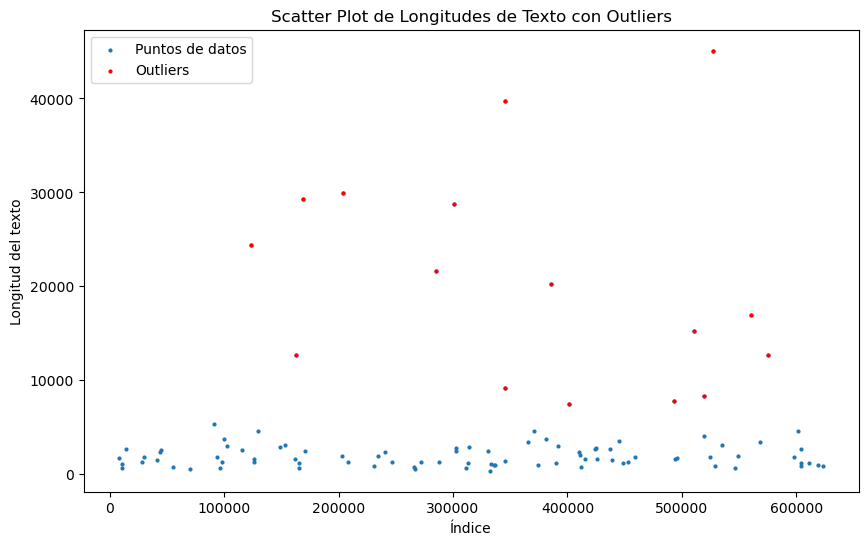

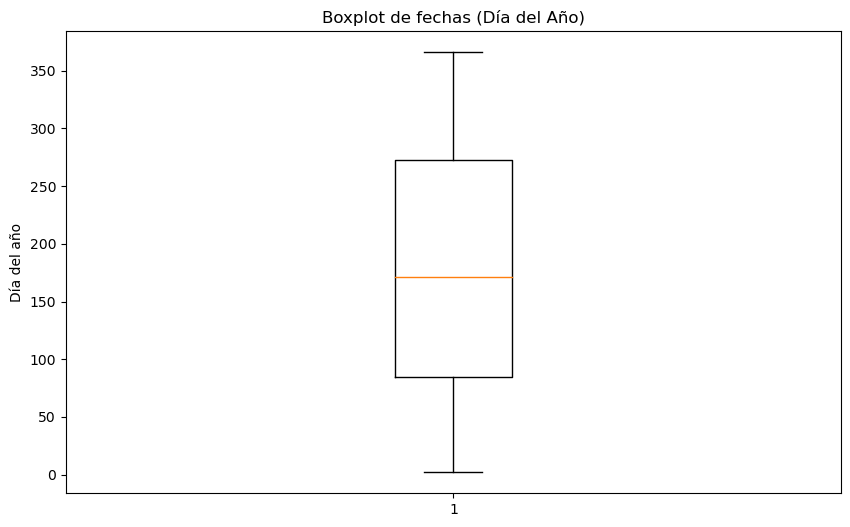

Entradas duplicadas: 6003
Textos duplicados principales y sus frecuencias:
"El texto de esta disposición no está disponible en HTML. Por favor, consulte la versión en PDF." - (984)
"Texto de acceso restringido En virtud del artículo 32 del Decreto 188/2018, de 9 de octubre, de Orde..." - (426)
"" - (294)
"Texto de acceso restringido En virtud del artículo 32 del Decreto 188/2018, de 9 de octubre, de Orde..." - (119)
"[VEASE ANEXO(S) EN EDICION IMPRESA DEL BOJA]" - (71)
"NO DISPONIBLE.El texto de esta disposición no está disponible en HTML. Por favor, consulte la versió..." - (71)
"height="15">." - (59)
"Ver esta disposición en fascículo 2 de 2 de este mismo número" - (50)
"Texto de acceso restringido En virtud del artículo 32 del Decreto 188/2018, de 9 de octubre, de Orde..." - (40)
"Texto de acceso restringido En virtud del artículo 32 del Decreto 188/2018, de 9 de octubre, de Orde..." - (39)


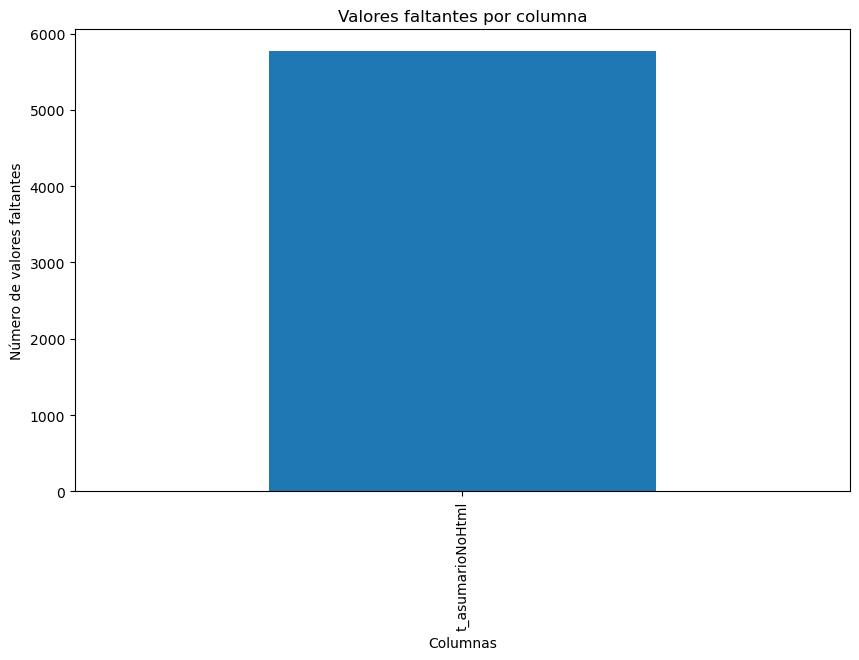

In [1]:
#Outliers BOJA

import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# Directorio de los archivos JSON
input_folder_path = 'Data_pag'

# Función para cargar datos de JSON en un DataFrame
def load_data(directory):
    data_frames = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read().strip()
                    if content:
                        try:
                            json_data = json.loads(content)
                            df = pd.json_normalize(json_data)
                            if not df.empty:
                                data_frames.append(df)
                            else:
                                print(f"El archivo {filename} está vacío después de la carga.")
                        except json.JSONDecodeError as e:
                            print(f"Error al decodificar JSON en {filename}: {e}")
                    else:
                        print(f"El archivo {filename} está vacío.")
            except ValueError as e:
                print(f"Error al leer {filename}: {e}")
            except Exception as e:
                print(f"Ocurrió un error inesperado al procesar {filename}: {e}")
    if data_frames:
        return pd.concat(data_frames, ignore_index=True)
    else:
        return pd.DataFrame()

# Cargar los datos
data = load_data(input_folder_path)

# Asegúrate de que los datos están correctamente cargados
print("Datos cargados:", data.shape)

if not data.empty:
    # Convertir la columna de fecha a tipo datetime
    data['d_date'] = pd.to_datetime(data['d_date'], format='%d/%m/%Y', errors='coerce')

    # Calcular la longitud del texto antes de la limpieza
    data['text_length'] = data['t_bodyNoHtml'].apply(len)

    # Calcular el rango intercuartílico (IQR)
    Q1 = data['text_length'].quantile(0.25)
    Q3 = data['text_length'].quantile(0.75)
    IQR = Q3 - Q1

    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")

    # Definir los límites para identificar outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Límite inferior: {lower_bound}, Límite superior: {upper_bound}")

    # Identificar outliers basados en la longitud del texto
    outliers_length = data[(data['text_length'] < lower_bound) | (data['text_length'] > upper_bound)]

    # Limitar la cantidad de datos a graficar
    sample_size = 100
    sample_data = data.sample(min(sample_size, len(data)))
    sample_outliers = sample_data[(sample_data['text_length'] < lower_bound) | (sample_data['text_length'] > upper_bound)]

    # Mostrar los outliers detectados
    plt.figure(figsize=(10, 6))
    plt.boxplot(sample_data['text_length'])
    plt.title('Boxplot de Longitudes de Texto')
    plt.ylabel('Longitud del texto')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(sample_data.index, sample_data['text_length'], label='Puntos de datos', s=4)
    plt.scatter(sample_outliers.index, sample_outliers['text_length'], color='red', label='Outliers', s=4)
    plt.xlabel('Índice')
    plt.ylabel('Longitud del texto')
    plt.title('Scatter Plot de Longitudes de Texto con Outliers')
    plt.legend()
    plt.show()

    # Fechas anómalas
    data['day_of_year'] = data['d_date'].dt.dayofyear

    plt.figure(figsize=(10, 6))
    plt.boxplot(data['day_of_year'].dropna())
    plt.title('Boxplot de fechas (Día del Año)')
    plt.ylabel('Día del año')
    plt.show()

    # Contenido repetido
    duplicates = data[data.duplicated(['t_bodyNoHtml'], keep=False)]
    print("Entradas duplicadas:", duplicates.shape[0])

    # Filtrar duplicados
    duplicate_counts = duplicates['t_bodyNoHtml'].value_counts()
    duplicates = duplicate_counts[duplicate_counts > 1]

    # Mostrar las frases más repetidas y su frecuencia
    print("Textos duplicados principales y sus frecuencias:")
    for text, freq in duplicates.head(10).items():
        truncated_text = (text[:100] + '...') if len(text) > 100 else text
        print(f"\"{truncated_text}\" - ({freq})")

    # Campos vacíos
    missing_values = data.isnull().sum()

    # Filtrar columnas con valores faltantes
    missing_values = missing_values[missing_values > 0]

    # Gráfico de barras de los valores faltantes
    plt.figure(figsize=(10, 6))
    missing_values.plot(kind='bar')
    plt.title('Valores faltantes por columna')
    plt.xlabel('Columnas')
    plt.ylabel('Número de valores faltantes')
    plt.show()
else:
    print("No se cargaron datos válidos.")



In [ ]:
#Procesamiento de texto. Normalización, eliminación de stopwords, lematización.

import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import os
import json

# Descargar las stopwords 
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def clean_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)
    return cleaned_text

input_folder_path = 'Data_pag'
output_folder_path = 'Data_pag_clean'

# Asegúrate de que el directorio de salida exista, si no, créalo
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

def process_json_files(input_folder_path, output_folder_path):
    for filename in os.listdir(input_folder_path):
        if filename.endswith('.json'):
            input_file_path = os.path.join(input_folder_path, filename)
            output_file_path = os.path.join(output_folder_path, filename)
            
            # Leer los datos del archivo JSON
            with open(input_file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                
            # Limpiar los campos de texto
            for record in data:
                record['clean_asumario'] = clean_text(record.get('t_asumarioNoHtml', ''))
                record['clean_body'] = clean_text(record.get('t_bodyNoHtml', ''))
            
            # Guardar los datos limpios en un nuevo archivo JSON
            with open(output_file_path, 'w', encoding='utf-8') as file:
                json.dump(data, file, indent=4, ensure_ascii=False)
            
            print(f"Processed and saved cleaned data for file: {filename}")

process_json_files(input_folder_path, output_folder_path)

In [ ]:
#tokenización Spacy y NER todos los años con WikiNeural. Trunca los textos demasiado largo para evitar errores MAX_TEXT_LENGTH = 200000

import json
import os
import spacy
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Cargar el modelo de SpaCy para español
nlp_spacy = spacy.load("es_core_news_sm")

# Cargar el modelo y el tokenizador de Hugging Face
model_name = "Babelscape/wikineural-multilingual-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Crear una tubería de NER
nlp_huggingface = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Establecer el límite máximo de caracteres a procesar por texto
MAX_TEXT_LENGTH = 200000  # Puedes ajustar este valor según sea necesario
MAX_TOKEN_LENGTH = 512  # Longitud máxima de tokens permitida por el modelo

# Ruta del directorio de entrada
input_dir = "Data_pag_clean"

# Ruta del directorio de salida
output_dir = "Data_pag_clean_NER"
os.makedirs(output_dir, exist_ok=True)

# Función para dividir el texto en segmentos manejables utilizando el tokenizador de spaCy
def split_text_into_chunks(text, max_length):
    doc = nlp_spacy(text)
    sentences = [sent.text for sent in doc.sents]
    chunks = []
    current_chunk = []
    current_length = 0
    
    for sentence in sentences:
        sentence_tokens = tokenizer.tokenize(sentence)
        if current_length + len(sentence_tokens) > max_length:
            chunks.append(current_chunk)
            current_chunk = []
            current_length = 0
        
        current_chunk.extend(sentence_tokens)
        current_length += len(sentence_tokens)
    
    if current_chunk:
        chunks.append(current_chunk)
    
    return chunks

# Función para realizar NER en los segmentos tokenizados
def ner_on_chunks(tokenized_chunks):
    entities = []
    
    for chunk in tokenized_chunks:
        # Convertir tokens de vuelta a texto
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        
        # Realizar NER
        ner_results = nlp_huggingface(chunk_text)
        
        # Extraer entidades
        entities_chunk = [(result["word"], result["entity_group"]) for result in ner_results]
        entities.extend(entities_chunk)
    
    return entities

# Función para procesar el texto y realizar tokenización y NER
def process_text(text):
    # Truncar el texto si es demasiado largo
    if len(text) > MAX_TEXT_LENGTH:
        text = text[:MAX_TEXT_LENGTH]

    # Dividir el texto en segmentos y realizar NER
    tokenized_chunks = split_text_into_chunks(text, MAX_TOKEN_LENGTH - 2)  # Reservar espacio para [CLS] y [SEP]
    entities = ner_on_chunks(tokenized_chunks)
    
    # Flatten los tokens
    tokens = [token for chunk in tokenized_chunks for token in chunk]
    
    return tokens, entities

# Procesar todos los archivos JSON en el directorio de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        input_file_path = os.path.join(input_dir, filename)
        
        # Leer el archivo JSON
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        # Tokenizar y extraer entidades de los campos clean_asumario y clean_body
        for record in data:
            tokens_asumario, entities_asumario = process_text(record.get("clean_asumario", ""))
            tokens_body, entities_body = process_text(record.get("clean_body", ""))
            
            record["tokenized_asumario"] = tokens_asumario
            record["entities_asumario"] = entities_asumario
            record["tokenized_body"] = tokens_body
            record["entities_body"] = entities_body
        
        # Extraer el año del nombre del archivo
        year = filename.split('.')[0]
        # Nombre del archivo de salida
        output_file_path = os.path.join(output_dir, f"{year}_tokenized_and_ner.json")
        
        # Guardar los resultados en un nuevo archivo JSON
        with open(output_file_path, "w", encoding="utf-8") as file:
            json.dump(data, file, ensure_ascii=False, indent=4)

        print(f"Tokenización y NER completados para {filename}. Archivo guardado en {output_file_path}")



In [ ]:
#Tokenizar BOE con Spacy
import json
import os
import spacy

# Cargar el modelo de SpaCy para español
nlp_spacy = spacy.load("es_core_news_sm")

# Establecer el límite máximo de caracteres a procesar por texto
MAX_TEXT_LENGTH = 200000  # Puedes ajustar este valor según sea necesario

# Ruta del directorio de entrada
input_dir = "BOE_JSON_clean"

# Ruta del directorio de salida
output_dir = "BOE_JSON_clean_tokenized"
os.makedirs(output_dir, exist_ok=True)

# Función para procesar el texto y realizar tokenización
def tokenize_text(text):
    # Truncar el texto si es demasiado largo
    if len(text) > MAX_TEXT_LENGTH:
        text = text[:MAX_TEXT_LENGTH]

    # Tokenizar el texto con SpaCy
    doc = nlp_spacy(text)
    tokens = [token.text for token in doc]

    return tokens

# Procesar todos los archivos JSON en el directorio de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        input_file_path = os.path.join(input_dir, filename)
        
        # Leer el archivo JSON
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        # Tokenizar el campo clean_asumario
        for record in data:
            tokens_asumario = tokenize_text(record.get("clean_asumario", ""))
            
            record["tokenized_asumario"] = tokens_asumario
            
            # Copiar los tokens al campo del cuerpo
            record["tokenized_body"] = tokens_asumario
        
        # Extraer el año del nombre del archivo
        year = filename.split('.')[0]
        # Nombre del archivo de salida
        output_file_path = os.path.join(output_dir, f"{year}_tokenized.json")
        
        # Guardar los resultados en un nuevo archivo JSON
        with open(output_file_path, "w", encoding="utf-8") as file:
            json.dump(data, file, ensure_ascii=False, indent=4)

        print(f"Tokenización completada para {filename}. Archivo guardado en {output_file_path}")



In [ ]:
#NER WikiNeural con BOE
import json
import os
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Cargar el modelo y el tokenizador de Hugging Face
model_name = "Babelscape/wikineural-multilingual-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Crear una tubería de NER
nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Directorios de entrada y salida
input_dir = "BOE_JSON_clean_tokenized"
output_dir = "BOE_JSON_clean_NER_WikiNeural"
os.makedirs(output_dir, exist_ok=True)

# Función para realizar NER en un texto
def perform_ner(text):
    ner_results = nlp(text)
    entities = [(result["word"], result["entity_group"]) for result in ner_results]
    return entities

# Procesar todos los archivos JSON en el directorio de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        input_file_path = os.path.join(input_dir, filename)
        
        # Leer el archivo JSON
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        # Aplicar NER a cada registro
        for record in data:
            asumario_text = record.get("t_asumarioNoHtml", "")
            body_text = record.get("t_bodyNoHtml", "")
            
            # Realizar NER sólo en el asumario y copiar los resultados al body
            entities_asumario = perform_ner(asumario_text)
            entities_body = entities_asumario  # Copiar los resultados del asumario al body
            
            record["entities_asumario"] = entities_asumario
            record["entities_body"] = entities_body
        
        # Nombre del archivo de salida
        output_file_path = os.path.join(output_dir, filename)
        
        # Guardar los resultados en un nuevo archivo JSON
        with open(output_file_path, "w", encoding="utf-8") as file:
            json.dump(data, file, ensure_ascii=False, indent=4)

        print(f"NER completado para {filename}. Archivo guardado en {output_file_path}")

print("Procesamiento completado.")


In [ ]:
#Embeddings BOJA
from sentence_transformers import SentenceTransformer
import json
import os

# Cargar el modelo de embeddings
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# Ruta del directorio de entrada y salida
input_dir = "Data_pag_clean_NER"
output_dir = "Data_pag_clean_NER_with_embeddings"
os.makedirs(output_dir, exist_ok=True)

# Función para generar embeddings de texto
def generate_embedding(text):
    return model.encode(text).tolist()

# Procesar todos los archivos JSON en el directorio de entrada
for filename in os.listdir(input_dir):
    if filename.endswith("_tokenized_and_ner.json"):
        input_file_path = os.path.join(input_dir, filename)
        
        # Leer los datos procesados
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        # Generar y agregar embeddings a cada registro
        for record in data:
            combined_text = " ".join(
                record.get("tokenized_asumario", []) +
                [ent[0] for ent in record.get("entities_asumario", [])] +
                record.get("tokenized_body", []) +
                [ent[0] for ent in record.get("entities_body", [])]
            )
            record["embedding"] = generate_embedding(combined_text)
        
        # Guardar los datos con embeddings en un nuevo archivo JSON
        output_file_path = os.path.join(output_dir, filename)
        with open(output_file_path, "w", encoding="utf-8") as file:
            json.dump(data, file, ensure_ascii=False, indent=4)
        
        print(f"Embeddings generados y guardados para {filename}. Archivo guardado en {output_file_path}")


In [ ]:
#Embeddings BOE

from sentence_transformers import SentenceTransformer
import json
import os

# Cargar el modelo de embeddings
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

# Ruta del directorio de entrada y salida
input_dir = "BOE_JSON_clean_NER_WikiNeural"  # Directorio de entrada con NER aplicado
output_dir = "BOE_JSON_clean_NER_with_embeddings"
os.makedirs(output_dir, exist_ok=True)

# Función para generar embeddings de texto
def generate_embedding(text):
    return model.encode(text).tolist()

# Procesar todos los archivos JSON en el directorio de entrada
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        input_file_path = os.path.join(input_dir, filename)
        
        # Leer los datos procesados
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        
        # Generar y agregar embeddings a cada registro
        for record in data:
            clean_asumario = record.get("clean_asumario", "")
            record["embedding"] = generate_embedding(clean_asumario)
        
        # Guardar los datos con embeddings en un nuevo archivo JSON
        output_file_path = os.path.join(output_dir, filename)
        with open(output_file_path, "w", encoding="utf-8") as file:
            json.dump(data, file, ensure_ascii=False, indent=4)
        
        print(f"Embeddings generados y guardados para {filename}. Archivo guardado en {output_file_path}")

print("Generación de embeddings completada.")


In [ ]:
#Eliminar índice de Elasticsearch

from elasticsearch import Elasticsearch

# Conectar a Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Configurar el índice
index_name = 'boja_index'

# Eliminar el índice si existe
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

print(f"Índice {index_name} eliminado correctamente.")

In [ ]:
#indexando BOJA  todos los años con highlights. Conversión de fecha

from elasticsearch import Elasticsearch, helpers
import json
import os
from datetime import datetime

# Conectar a Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Configurar el índice
index_name = 'boja_index'

# Verificar si el índice existe y crearlo si no existe
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)  # Considerar no borrar si no es necesario

es.indices.create(index=index_name, body={
    "settings": {
        "number_of_shards": 1,  # Optimizar según la carga de trabajo y el hardware
        "number_of_replicas": 0  # Configurar según el entorno de producción o desarrollo
    },
    "mappings": {
        "properties": {
            "t_publicUrl": {"type": "text"},
            "d_date": {"type": "date", "format": "yyyy-MM-dd"},  # Especificar el formato de la fecha
            "t_asumarioNoHtml": {"type": "text", "term_vector": "with_positions_offsets"},  # Para mejorar soporte de highlights
            "t_bodyNoHtml": {"type": "text", "term_vector": "with_positions_offsets"},
            "entities_asumario": {"type": "text"},
            "entities_body": {"type": "text"},
            "embedding": {"type": "dense_vector", "dims": 384}
        }
    }
})

# Función para convertir fechas al formato YYYY-MM-DD
def convert_date(date_str):
    try:
        return datetime.strptime(date_str, "%d/%m/%Y").strftime("%Y-%m-%d")
    except ValueError as e:
        print(f"Error al convertir la fecha: {e}")
        return None

# Función para indexar los documentos
def index_documents(data):
    actions = []
    for record in data:
        if '_id' not in record or 't_publicUrl' not in record or 'd_date' not in record:
            print(f"Registro con id {record.get('_id', 'sin id')} falta campos obligatorios.")
            continue

        es_date = convert_date(record['d_date'])
        if not es_date:
            print(f"Registro con id {record['_id']} tiene una fecha inválida: {record['d_date']}")
            continue

        try:
            action = {
                "_index": index_name,
                "_id": record["_id"],
                "_source": {
                    "t_publicUrl": record["t_publicUrl"],
                    "d_date": es_date,
                    "t_asumarioNoHtml": record.get("t_asumarioNoHtml", ""),
                    "t_bodyNoHtml": record.get("t_bodyNoHtml", ""),
                    "entities_asumario": " ".join([ent[0] for ent in record.get("entities_asumario", [])]),
                    "entities_body": " ".join([ent[0] for ent in record.get("entities_body", [])]),
                    "embedding": record.get("embedding", [])
                }
            }
            actions.append(action)
        except Exception as e:
            print(f"Error al procesar el registro con id {record['_id']}: {e}")

    try:
        helpers.bulk(es, actions)
    except Exception as e:
        print(f"Error al indexar los documentos: {e}")

# Leer y procesar datos
input_dir = "Data_pag_clean_NER_with_embeddings"
for filename in os.listdir(input_dir):
    if filename.endswith("_tokenized_and_ner.json"):
        input_file_path = os.path.join(input_dir, filename)
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        print(f"Indexando documentos del archivo: {filename}")
        index_documents(data)


In [ ]:
# Indexando BOE con Elasticsearch
from elasticsearch import Elasticsearch, helpers
import json
import os

# Conectar a Elasticsearch
es = Elasticsearch([{'host': 'localhost', 'port': 9200, 'scheme': 'http'}])

# Configurar el índice
index_name = 'boe_index'

# Verificar si el índice existe y crearlo si no existe
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)  # Considerar no borrar si no es necesario

es.indices.create(index=index_name, body={
    "settings": {
        "number_of_shards": 1,  # Optimizar según la carga de trabajo y el hardware
        "number_of_replicas": 0  # Configurar según el entorno de producción o desarrollo
    },
    "mappings": {
        "properties": {
            "t_publicUrl": {"type": "text"},
            "d_date": {"type": "date", "format": "yyyy-MM-dd"},  # Especificar el formato de la fecha
            "t_asumarioNoHtml": {"type": "text", "term_vector": "with_positions_offsets"},  # Para mejorar soporte de highlights
            "t_bodyNoHtml": {"type": "text", "term_vector": "with_positions_offsets"},
            "entities_asumario": {"type": "text"},
            "entities_body": {"type": "text"},
            "embedding": {"type": "dense_vector", "dims": 768}
        }
    }
})

# Función para indexar los documentos
def index_documents(data):
    actions = []
    for record in data:
        if '_id' not in record or 't_publicUrl' not in record or 'd_date' not in record:
            print(f"Registro con id {record.get('_id', 'sin id')} falta campos obligatorios.")
            continue

        try:
            action = {
                "_index": index_name,
                "_id": record["_id"],
                "_source": {
                    "t_publicUrl": record["t_publicUrl"],
                    "d_date": record["d_date"],  # Usar directamente la fecha del JSON
                    "t_asumarioNoHtml": record.get("t_asumarioNoHtml", ""),
                    "t_bodyNoHtml": record.get("t_bodyNoHtml", ""),
                    "entities_asumario": " ".join([ent[0] for ent in record.get("entities_asumario", [])]),
                    "entities_body": " ".join([ent[0] for ent in record.get("entities_body", [])]),
                    "embedding": record.get("embedding", [])
                }
            }
            actions.append(action)
        except Exception as e:
            print(f"Error al procesar el registro con id {record['_id']}: {e}")

    try:
        helpers.bulk(es, actions)
    except Exception as e:
        print(f"Error al indexar los documentos: {e}")

# Leer y procesar datos
input_dir = "BOE_JSON_clean_NER_with_embeddings"
for filename in os.listdir(input_dir):
    if filename.endswith(".json"):
        input_file_path = os.path.join(input_dir, filename)
        with open(input_file_path, "r", encoding="utf-8") as file:
            data = json.load(file)
        print(f"Indexando documentos del archivo: {filename}")
        index_documents(data)

print("Indexación completada.")



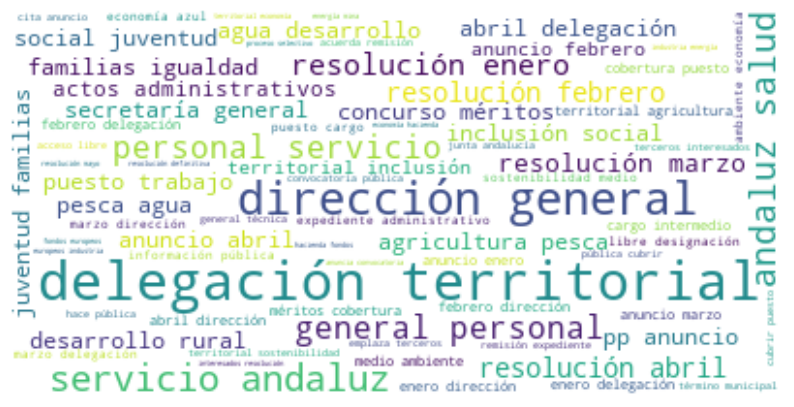

In [16]:
#Nube de palabras BOJA

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import json

# Ruta del directorio que contiene los archivos JSON
ruta_directorio = "Data_pag_clean_NER_with_embeddings"

# Lista para almacenar los tokens de 'tokenized_asumario'
tokens_asumario = []

# Itera sobre los archivos en el directorio
for nombre_archivo in os.listdir(ruta_directorio):
    if nombre_archivo.endswith(".json"):
        ruta_archivo = os.path.join(ruta_directorio, nombre_archivo)
        with open(ruta_archivo, "r", encoding="utf-8") as archivo_json:
            data = json.load(archivo_json)
            for record in data:
                tokens_asumario.extend(record.get("tokenized_asumario", []))

# Combina todos los tokens en un solo texto
all_tokens = " ".join(" ".join(record["tokenized_asumario"]) for record in data)

# Crea la nube de palabras con fondo blanco y preferencia por palabras horizontales
wordcloud = WordCloud(background_color="white", prefer_horizontal=0.9).generate(all_tokens)

# Muestra la imagen de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Guarda la imagen de la nube de palabras en un archivo
wordcloud.to_file("nube_de_palabras.png")


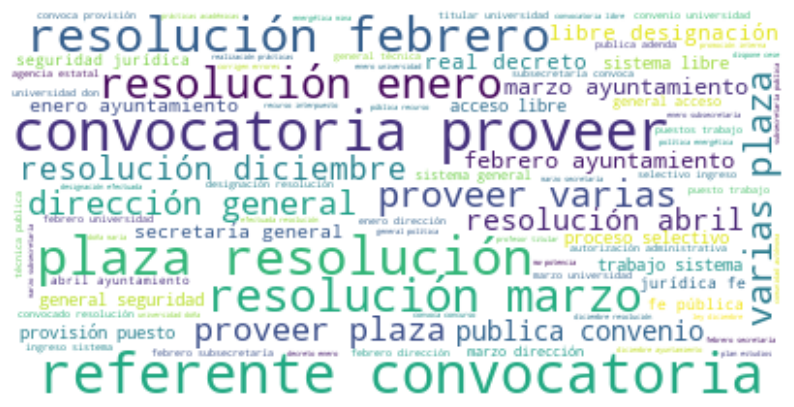

In [1]:
#Nube de palabras BOE

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
import json

# Ruta del directorio que contiene los archivos JSON
ruta_directorio = "BOE_JSON_clean_NER_with_embeddings"

# Lista para almacenar los tokens de 'tokenized_asumario'
tokens_asumario = []

# Itera sobre los archivos en el directorio
for nombre_archivo in os.listdir(ruta_directorio):
    if nombre_archivo.endswith(".json"):
        ruta_archivo = os.path.join(ruta_directorio, nombre_archivo)
        with open(ruta_archivo, "r", encoding="utf-8") as archivo_json:
            data = json.load(archivo_json)
            for record in data:
                tokens_asumario.extend(record.get("tokenized_asumario", []))

# Combina todos los tokens en un solo texto
all_tokens = " ".join(" ".join(record["tokenized_asumario"]) for record in data)

# Crea la nube de palabras con fondo blanco y preferencia por palabras horizontales
wordcloud = WordCloud(background_color="white", prefer_horizontal=0.9).generate(all_tokens)

# Muestra la imagen de la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


# Guarda la imagen de la nube de palabras en un archivo
wordcloud.to_file("nube_de_palabras_boe.png")